An implementation of sequence to sequence learning for performing addition
Input: "535+61"
Output: "596"
Padding is handled by using a repeated sentinel character (space)
Input may optionally be reversed, shown to increase performance in many tasks in:
"Learning to Execute"
http://arxiv.org/abs/1410.4615
and
"Sequence to Sequence Learning with Neural Networks"
http://papers.nips.cc/paper/5346-sequence-to-sequence-learning-with-neural-networks.pdf
Theoretically it introduces shorter term dependencies between source and target.

Modified to train RNN to conjugate past tense of verbs. Data currently taken from UCLA dataset on verb conjugation.

Code taken, modified from https://github.com/keras-team/keras/blob/master/examples/addition_rnn.py

In [1]:
from __future__ import print_function
from keras.models import Sequential
from keras import layers
import numpy as np
from six.moves import range
import csv
from keras.regularizers import L1L2
from matplotlib import pyplot

/Users/etang/anaconda3/envs/nlu/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Character Table

Taking in our string of numbers/operations as a string of characters, we must vectorize each character as a new input to our RNN. 

We first create a table mapping each character in our vocabulary (in our case, this is the numbers 0-9 and addition symbol '+') to a unique integer index. We also create a table mapping back the other way. 

To encode a string, we convert each character in the string to a one-hot vector with the character index as 1 and all other indices as 0. We also feed in the parameter `num_rows` as a maximum length of our string, equivalent to padding all strings to a specified length.

To decode an output array x, we take each vector of the string (representing a component) and decode it back into its most likely character. NOTE: I'm a little unclear about how we deal with variable-length answers. Maybe those are just decoded into space characters?

In [2]:
class CharacterTable(object):
    """Given a set of characters:
    + Encode them to a one hot integer representation
    + Decode the one hot integer representation to their character output
    + Decode a vector of probabilities to their character output
    """
    def __init__(self, chars):
        """Initialize character table.
        # Arguments
            chars: Characters that can appear in the input.
        """
        self.chars = sorted(set(chars))
        self.char_indices = dict((c, i) for i, c in enumerate(self.chars))
        self.indices_char = dict((i, c) for i, c in enumerate(self.chars))

    def encode(self, C, num_rows):
        """One hot encode given string C.
        # Arguments
            num_rows: Number of rows in the returned one hot encoding. This is
                used to keep the # of rows for each data the same.
        """
        x = np.zeros((num_rows, len(self.chars)))
        for i, c in enumerate(C):
            x[i, self.char_indices[c]] = 1
        return x

    def decode(self, x, calc_argmax=True):
        if calc_argmax:
            x = x.argmax(axis=-1)
        return ''.join(self.indices_char[x] for x in x)


In [3]:
class colors:
    ok = '\033[92m'
    fail = '\033[91m'
    close = '\033[0m'


## Model Parameters

These parameters are now heuristically chosen based on the data in our database.

MAXLEN is the maximum length of any one input (or can be truncated below that). Chosen as 14, for max input length from UCLA dataset.  
TRAINING_SIZE is an approximation (I think) for the number of examples in our dataset.  
`chars` is a string with all characters that can be used in our inputs/outputs. We also add a space for padding.

REVERSE is not currently used, but it should indicate whether we feed the inputs in standard order or reversed.

In [6]:
# Parameters for the model and dataset.
TRAINING_SIZE = 50000
MAXLEN_INPUT = 16
MAXLEN_OUTPUT = 17
REVERSE = True

chars = 'abcdefghijklmnopqrstuvwxyz '
ctable = CharacterTable(chars)


## Data Processing for Verb Tenses

We read in the data from our CSV of UCLA's verb tenses. Then we vectorize them using the Character class and model parameters defined above.

In [7]:
data_file = 'wordlist.csv'

import re # For stripping non-alphanumeric characters
present = []
past = []
with open(data_file) as csvfile:
    readCSV = csv.reader(csvfile, delimiter=',')
    for row in readCSV:
        if not (re.search(r'\W+', row[0]) or re.search(r'\W+', row[1])):
            # Only add if all alphanumeric
            # Then pad inputs with spaces
            present_word = row[0] + ' ' * (MAXLEN_INPUT - len(row[0]))
            if REVERSE:
                # Reverse the query, e.g., '12+345  ' becomes '  543+21'.
                present_word = present_word[::-1]
            present.append(present_word)
            past_word = row[1] + ' ' * (MAXLEN_OUTPUT - len(row[1]))
            past.append(past_word)

print(list(zip(present, past))[:10])
print("MAXLEN of input: ", max([len(s) for s in present]))
print("MAXLEN of output: ", max([len(s) for s in past]))

assert(len(present)==len(past))
print("Num examples: ", len(present))

[('         nodnaba', 'abandoned        '), ('           esaba', 'abased           '), ('           hsaba', 'abashed          '), ('           etaba', 'abated           '), ('      etaiverbba', 'abbreviated      '), ('        etacidba', 'abdicated        '), ('          tcudba', 'abducted         '), ('            teba', 'abetted          '), ('           rohba', 'abhorred         '), ('           ediba', 'abode            ')]
MAXLEN of input:  16
MAXLEN of output:  17
Num examples:  6872


## Data Processing

Vectorize data using the Character library and previously set parameters

In [8]:
print('Vectorization...')
x = np.zeros((len(past), MAXLEN_INPUT, len(chars)), dtype=np.bool)
y = np.zeros((len(past), MAXLEN_OUTPUT, len(chars)), dtype=np.bool)
for i, word in enumerate(present):
    x[i] = ctable.encode(word, MAXLEN_INPUT)
for i, word in enumerate(past):
    y[i] = ctable.encode(word, MAXLEN_OUTPUT)

# Shuffle (x, y) in unison as the later parts of x will almost all be larger
# digits.
indices = np.arange(len(y))
np.random.shuffle(indices)
x = x[indices]
y = y[indices]

# Explicitly set apart 10% for validation data that we never train over.
split_at = len(x) - len(x) // 10
(x_train, x_val) = x[:split_at], x[split_at:]
(y_train, y_val) = y[:split_at], y[split_at:]

print('Training Data:')
print(x_train.shape)
print(y_train.shape)

print('Validation Data:')
print(x_val.shape)
print(y_val.shape)

Vectorization...
Training Data:
(6185, 16, 27)
(6185, 17, 27)
Validation Data:
(687, 16, 27)
(687, 17, 27)


## Setting up Model

In [14]:
# Try replacing GRU, or SimpleRNN.
RNN = layers.LSTM
HIDDEN_SIZE = 128
BATCH_SIZE = 128
LAYERS = 3


print('Build model...')
model = Sequential()
# "Encode" the input sequence using an RNN, producing an output of HIDDEN_SIZE.
# Note: In a situation where your input sequences have a variable length,
# use input_shape=(None, num_feature).
model.add(RNN(HIDDEN_SIZE, input_shape=(MAXLEN_INPUT, len(chars))))
# As the decoder RNN's input, repeatedly provide with the last hidden state of
# RNN for each time step. Repeat 'DIGITS + 1' times as that's the maximum
# length of output, e.g., when DIGITS=3, max output is 999+999=1998.
model.add(layers.RepeatVector(MAXLEN_OUTPUT))
# The decoder RNN could be multiple layers stacked or a single layer.
for _ in range(LAYERS):
    # By setting return_sequences to True, return not only the last output but
    # all the outputs so far in the form of (num_samples, timesteps,
    # output_dim). This is necessary as TimeDistributed in the below expects
    # the first dimension to be the timesteps.
    model.add(RNN(HIDDEN_SIZE, return_sequences=True))

# Apply a dense layer to the every temporal slice of an input. For each of step
# of the output sequence, decide which character should be chosen.
model.add(layers.TimeDistributed(layers.Dense(len(chars))))
model.add(layers.Activation('softmax'))
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()

Build model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 128)               79872     
_________________________________________________________________
repeat_vector_3 (RepeatVecto (None, 17, 128)           0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 17, 128)           131584    
_________________________________________________________________
lstm_11 (LSTM)               (None, 17, 128)           131584    
_________________________________________________________________
lstm_12 (LSTM)               (None, 17, 128)           131584    
_________________________________________________________________
time_distributed_3 (TimeDist (None, 17, 27)            3483      
_________________________________________________________________
activation_3 (Activation)    (None, 17, 27)            0     

## Training, Validating Model

In [15]:
# Print validation examples and classifications from the dataset
def classify_val_examples():
    # Select 10 samples from the validation set at random so we can visualize
    # errors.
    for i in range(10):
        ind = np.random.randint(0, len(x_val))
        rowx, rowy = x_val[np.array([ind])], y_val[np.array([ind])]
        preds = model.predict_classes(rowx, verbose=0)
        q = ctable.decode(rowx[0])
        correct = ctable.decode(rowy[0])
        guess = ctable.decode(preds[0], calc_argmax=False)
        print('Q', q[::-1] if REVERSE else q, end=' ')
        print('T', correct, end=' ')
        if correct == guess:
            print(colors.ok + '☑' + colors.close, end=' ')
        else:
            print(colors.fail + '☒' + colors.close, end=' ')
        print(guess)

#Takes list of past loss and val_loss values, plots them
def plot_learning_curves(loss, val_loss):
    pyplot.clf()
    pyplot.plot(loss)
    pyplot.plot(val_loss)
    pyplot.title('model train vs validation loss')
    pyplot.ylabel('loss')
    pyplot.xlabel('epoch')
    pyplot.legend(['train', 'validation'], loc='upper right')
    pyplot.show()


--------------------------------------------------
Iteration 1
Train on 6185 samples, validate on 687 samples
Epoch 1/1
6185/6185 [==============================] - 8s 1ms/step - loss: 1.3451 - acc: 0.6078 - val_loss: 1.3059 - val_acc: 0.6297
Q stamp            T stamped           ☒ eeeeeed          
Q input            T inputted          ☒ eeeeeed          
Q skateboard       T skateboarded      ☒ reeeeeeeeedd     
Q prepossess       T prepossessed      ☒ reeeeeeeeed      
Q cuss             T cussed            ☒ eeeeed           
Q hoot             T hooted            ☒ eeeeed           
Q sin              T sinned            ☒ eeeeed           
Q golf             T golfed            ☒ eeeeed           
Q pat              T patted            ☒ eeeeed           
Q paralyze         T paralyzed         ☒ reeeeeeed        

--------------------------------------------------
Iteration 2
Train on 6185 samples, validate on 687 samples
Epoch 1/1
6185/6185 [==============================] - 

6185/6185 [==============================] - 8s 1ms/step - loss: 1.1267 - acc: 0.6630 - val_loss: 1.1341 - val_acc: 0.6608
Q skateboard       T skateboarded      ☒ eeeeeeriated     
Q survive          T survived          ☒ eeerated         
Q tilt             T tilted            ☒ eealed           
Q vignette         T vignetted         ☒ eeeertted        
Q furl             T furled            ☒ eealed           
Q volley           T volleyed          ☒ eeearted         
Q flock            T flocked           ☒ eeoated          
Q behold           T beheld            ☒ eeerated         
Q cloy             T cloyed            ☒ eealed           
Q objectify        T objectified       ☒ eeeeeriited      

--------------------------------------------------
Iteration 11
Train on 6185 samples, validate on 687 samples
Epoch 1/1
6185/6185 [==============================] - 8s 1ms/step - loss: 1.1067 - acc: 0.6698 - val_loss: 1.1320 - val_acc: 0.6603
Q rave             T raved             ☒ e

6185/6185 [==============================] - 8s 1ms/step - loss: 0.9516 - acc: 0.7117 - val_loss: 0.9712 - val_acc: 0.7073
Q welch            T welched           ☒ eeusled          
Q veil             T veiled            ☒ ealled           
Q promise          T promised          ☒ eooiiled         
Q disengage        T disengaged        ☒ eeooooiged       
Q quote            T quoted            ☒ eaated           
Q melt             T melted            ☒ easted           
Q raise            T raised            ☒ eaited           
Q sync             T synced            ☒ eailed           
Q spring           T sprang            ☒ eooooged         
Q audition         T auditioned        ☒ eerrroined       

--------------------------------------------------
Iteration 20
Train on 6185 samples, validate on 687 samples
Epoch 1/1
6185/6185 [==============================] - 8s 1ms/step - loss: 0.9352 - acc: 0.7159 - val_loss: 0.9550 - val_acc: 0.7078
Q dovetail         T dovetailed        ☒ e

6185/6185 [==============================] - 8s 1ms/step - loss: 0.7804 - acc: 0.7648 - val_loss: 0.8008 - val_acc: 0.7571
Q carve            T carved            ☒ serred           
Q condition        T conditioned       ☒ sessttioned      
Q safeguard        T safeguarded       ☒ seaaalarded      
Q impel            T impelled          ☒ seeeled          
Q negative         T negatived         ☒ setttuved        
Q refile           T refiled           ☒ siiiled          
Q bulletin         T bulletined        ☒ sesttiined       
Q denude           T denuded           ☒ seddded          
Q initial          T initialed         ☒ settiiled        
Q encounter        T encountered       ☒ senssttered      

--------------------------------------------------
Iteration 29
Train on 6185 samples, validate on 687 samples
Epoch 1/1
6185/6185 [==============================] - 8s 1ms/step - loss: 0.7562 - acc: 0.7728 - val_loss: 0.7864 - val_acc: 0.7591
Q cash             T cashed            ☒ s

6185/6185 [==============================] - 8s 1ms/step - loss: 0.5953 - acc: 0.8178 - val_loss: 0.6544 - val_acc: 0.8013
Q underachieve     T underachieved     ☒ seaaaacteved     
Q swig             T swigged           ☒ srigged          
Q listen           T listened          ☒ cittened         
Q clash            T clashed           ☒ slashed          
Q disfavor         T disfavored        ☒ rinuuvured       
Q hesitate         T hesitated         ☒ citttated        
Q hasten           T hastened          ☒ sattened         
Q hull             T hulled            ☒ sllled           
Q appall           T appalled          ☒ saaalled         
Q allot            T allotted          ☒ blloted          

--------------------------------------------------
Iteration 38
Train on 6185 samples, validate on 687 samples
Epoch 1/1
6185/6185 [==============================] - 9s 2ms/step - loss: 0.5726 - acc: 0.8243 - val_loss: 0.6058 - val_acc: 0.8145
Q menstruate       T menstruated       ☒ r

6185/6185 [==============================] - 8s 1ms/step - loss: 0.4120 - acc: 0.8729 - val_loss: 0.4530 - val_acc: 0.8591
Q relight          T relighted         ☒ regighted        
Q engulf           T engulfed          ☒ endulged         
Q feign            T feigned           ☒ figgged          
Q twitter          T twittered         ☒ soittered        
Q reduplicate      T reduplicated      ☒ reeebiccated     
Q wed              T wedded            ☒ weded            
Q hyperventilate   T hyperventilated   ☒ reeeeeeetilated  
Q enthuse          T enthused          ☒ enstused         
Q cuss             T cussed            ☒ sussed           
Q thwack           T thwacked          ☒ shracked         

--------------------------------------------------
Iteration 47
Train on 6185 samples, validate on 687 samples
Epoch 1/1
6185/6185 [==============================] - 8s 1ms/step - loss: 0.3847 - acc: 0.8820 - val_loss: 0.4144 - val_acc: 0.8737
Q scrimmage        T scrimmaged        ☒ s

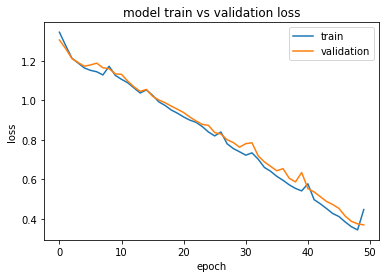


--------------------------------------------------
Iteration 51
Train on 6185 samples, validate on 687 samples
Epoch 1/1
6185/6185 [==============================] - 8s 1ms/step - loss: 0.3077 - acc: 0.9076 - val_loss: 0.3326 - val_acc: 0.9019
Q nickname         T nicknamed         ☒ inccaamed        
Q lateral          T lateraled         ☒ cartraled        
Q bloom            T bloomed           ☑ bloomed          
Q dogleg           T doglegged         ☒ doggeled         
Q hammer           T hammered          ☒ cammered         
Q incapacitate     T incapacitated     ☒ incaaciicated    
Q surfboard        T surfboarded       ☒ soubbborded      
Q explain          T explained         ☑ explained        
Q remark           T remarked          ☑ remarked         
Q pat              T patted            ☑ patted           

--------------------------------------------------
Iteration 52
Train on 6185 samples, validate on 687 samples
Epoch 1/1
6185/6185 [==============================] 

6185/6185 [==============================] - 8s 1ms/step - loss: 0.1728 - acc: 0.9496 - val_loss: 0.2119 - val_acc: 0.9351
Q rebate           T rebated           ☑ rebated          
Q drain            T drained           ☑ drained          
Q turn             T turned            ☑ turned           
Q mesmerize        T mesmerized        ☒ miseerized       
Q barnstorm        T barnstormed       ☒ barnscormed      
Q procrastinate    T procrastinated    ☒ prrporstinated   
Q bewitch          T bewitched         ☑ bewitched        
Q heel             T heeled            ☑ heeled           
Q salt             T salted            ☑ salted           
Q gimlet           T gimleted          ☒ gibleted         

--------------------------------------------------
Iteration 61
Train on 6185 samples, validate on 687 samples
Epoch 1/1
6185/6185 [==============================] - 8s 1ms/step - loss: 0.1565 - acc: 0.9544 - val_loss: 0.2158 - val_acc: 0.9356
Q reseal           T resealed          ☒ r

6185/6185 [==============================] - 8s 1ms/step - loss: 0.1256 - acc: 0.9637 - val_loss: 0.1691 - val_acc: 0.9487
Q mourn            T mourned           ☑ mourned          
Q reassign         T reassigned        ☑ reassigned       
Q pantomime        T pantomimed        ☒ pattmmmmed       
Q invigorate       T invigorated       ☑ invigorated      
Q reverberate      T reverberated      ☒ reverbbrated     
Q miscarry         T miscarried        ☑ miscarried       
Q crowd            T crowded           ☑ crowded          
Q bulletin         T bulletined        ☒ bulyhhined       
Q bush             T bushed            ☑ bushed           
Q overjoy          T overjoyed         ☒ overooied        

--------------------------------------------------
Iteration 70
Train on 6185 samples, validate on 687 samples
Epoch 1/1
6185/6185 [==============================] - 8s 1ms/step - loss: 0.1052 - acc: 0.9710 - val_loss: 0.1703 - val_acc: 0.9483
Q campaign         T campaigned        ☒ c

6185/6185 [==============================] - 8s 1ms/step - loss: 0.0630 - acc: 0.9835 - val_loss: 0.1458 - val_acc: 0.9568
Q sin              T sinned            ☑ sinned           
Q improve          T improved          ☑ improved         
Q sun              T sunned            ☑ sunned           
Q channelize       T channelized       ☑ channelized      
Q reattempt        T reattempted       ☒ rettteapted      
Q cerebrate        T cerebrated        ☒ cerbbrated       
Q lag              T lagged            ☑ lagged           
Q reproach         T reproached        ☑ reproached       
Q abase            T abased            ☑ abased           
Q inactivate       T inactivated       ☒ incaniiated      

--------------------------------------------------
Iteration 79
Train on 6185 samples, validate on 687 samples
Epoch 1/1
6185/6185 [==============================] - 8s 1ms/step - loss: 0.0699 - acc: 0.9813 - val_loss: 0.1702 - val_acc: 0.9486
Q paint            T painted           ☑ p

6185/6185 [==============================] - 8s 1ms/step - loss: 0.0430 - acc: 0.9905 - val_loss: 0.1326 - val_acc: 0.9621
Q dawn             T dawned            ☑ dawned           
Q plaster          T plastered         ☑ plastered        
Q imprecate        T imprecated        ☒ impretated       
Q birdie           T birdied           ☒ biriied          
Q price            T priced            ☑ priced           
Q unfold           T unfolded          ☑ unfolded         
Q enthuse          T enthused          ☑ enthused         
Q headhunt         T headhunted        ☒ headhossed       
Q adjudge          T adjudged          ☑ adjudged         
Q rezone           T rezoned           ☑ rezoned          

--------------------------------------------------
Iteration 88
Train on 6185 samples, validate on 687 samples
Epoch 1/1
6185/6185 [==============================] - 8s 1ms/step - loss: 0.0390 - acc: 0.9916 - val_loss: 0.1289 - val_acc: 0.9618
Q vet              T vetted            ☑ v

6185/6185 [==============================] - 8s 1ms/step - loss: 0.0234 - acc: 0.9965 - val_loss: 0.1305 - val_acc: 0.9639
Q bandy            T bandied           ☑ bandied          
Q simplify         T simplified        ☑ simplified       
Q invigorate       T invigorated       ☑ invigorated      
Q torpedo          T torpedoed         ☒ torreede         
Q decompose        T decomposed        ☑ decomposed       
Q bestir           T bestirred         ☒ bestired         
Q divulge          T divulged          ☒ divulled         
Q bamboozle        T bamboozled        ☒ bammooied        
Q lust             T lusted            ☑ lusted           
Q reecho           T reechoed          ☑ reechoed         

--------------------------------------------------
Iteration 97
Train on 6185 samples, validate on 687 samples
Epoch 1/1
6185/6185 [==============================] - 8s 1ms/step - loss: 0.0223 - acc: 0.9966 - val_loss: 0.1288 - val_acc: 0.9642
Q engulf           T engulfed          ☒ e

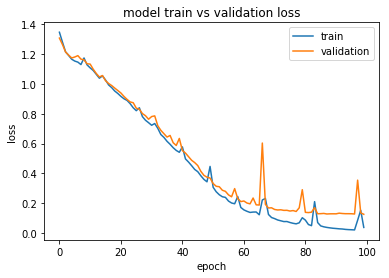


--------------------------------------------------
Iteration 101
Train on 6185 samples, validate on 687 samples
Epoch 1/1
6185/6185 [==============================] - 8s 1ms/step - loss: 0.0253 - acc: 0.9955 - val_loss: 0.1223 - val_acc: 0.9646
Q strop            T stropped          ☑ stropped         
Q throb            T throbbed          ☑ throbbed         
Q descend          T descended         ☑ descended        
Q thaw             T thawed            ☑ thawed           
Q procrastinate    T procrastinated    ☒ procrrntinated   
Q bumble           T bumbled           ☑ bumbled          
Q exorcize         T exorcized         ☑ exorcized        
Q rejudge          T rejudged          ☑ rejudged         
Q ghost            T ghosted           ☒ hhosted          
Q confuse          T confused          ☑ confused         

--------------------------------------------------
Iteration 102
Train on 6185 samples, validate on 687 samples
Epoch 1/1
6185/6185 [==============================

6185/6185 [==============================] - 8s 1ms/step - loss: 0.0111 - acc: 0.9993 - val_loss: 0.1254 - val_acc: 0.9675
Q comment          T commented         ☑ commented        
Q peek             T peeked            ☑ peeked           
Q slurp            T slurped           ☑ slurped          
Q sin              T sinned            ☑ sinned           
Q gird             T girded            ☑ girded           
Q unfold           T unfolded          ☑ unfolded         
Q transport        T transported       ☑ transported      
Q birdie           T birdied           ☒ biriied          
Q readjust         T readjusted        ☒ readdusted       
Q misprint         T misprinted        ☑ misprinted       

--------------------------------------------------
Iteration 111
Train on 6185 samples, validate on 687 samples
Epoch 1/1
6185/6185 [==============================] - 8s 1ms/step - loss: 0.0107 - acc: 0.9992 - val_loss: 0.1247 - val_acc: 0.9662
Q view             T viewed            ☒ 

6185/6185 [==============================] - 8s 1ms/step - loss: 0.0067 - acc: 0.9998 - val_loss: 0.1290 - val_acc: 0.9687
Q imagine          T imagined          ☒ imaained         
Q rehearse         T rehearsed         ☒ rehharsed        
Q feign            T feigned           ☑ feigned          
Q listen           T listened          ☑ listened         
Q photosynthesize  T photosynthesized  ☒ prottttsttalized 
Q field            T fielded           ☑ fielded          
Q editorialize     T editorialized     ☒ editiiialized    
Q boondoggle       T boondoggled       ☒ boodddggled      
Q roil             T roiled            ☑ roiled           
Q decoupage        T decoupaged        ☒ decouuaged       

--------------------------------------------------
Iteration 120
Train on 6185 samples, validate on 687 samples
Epoch 1/1
6185/6185 [==============================] - 8s 1ms/step - loss: 0.0064 - acc: 0.9998 - val_loss: 0.1289 - val_acc: 0.9685
Q brew             T brewed            ☑ 

6185/6185 [==============================] - 8s 1ms/step - loss: 0.0042 - acc: 1.0000 - val_loss: 0.1348 - val_acc: 0.9689
Q aliment          T alimented         ☑ alimented        
Q dovetail         T dovetailed        ☑ dovetailed       
Q ghost            T ghosted           ☑ ghosted          
Q fail             T failed            ☑ failed           
Q defeat           T defeated          ☑ defeated         
Q possess          T possessed         ☑ possessed        
Q photosynthesize  T photosynthesized  ☒ proytttsttalized 
Q lag              T lagged            ☑ lagged           
Q scrape           T scraped           ☑ scraped          
Q kennel           T kenneled          ☑ kenneled         

--------------------------------------------------
Iteration 129
Train on 6185 samples, validate on 687 samples
Epoch 1/1
6185/6185 [==============================] - 8s 1ms/step - loss: 0.0040 - acc: 1.0000 - val_loss: 0.1358 - val_acc: 0.9691
Q turbocharge      T turbocharged      ☑ 

6185/6185 [==============================] - 8s 1ms/step - loss: 0.0559 - acc: 0.9817 - val_loss: 0.1583 - val_acc: 0.9544
Q negative         T negatived         ☒ negatiied        
Q forestall        T forestalled       ☒ forestaaled      
Q regrind          T reground          ☑ reground         
Q subtitle         T subtitled         ☒ subtttled        
Q overestimate     T overestimated     ☒ overxetimated    
Q misinterpret     T misinterpreted    ☒ minintertereedd  
Q rustproof        T rustproofed       ☒ ruttrroofed      
Q outdo            T outdid            ☒ outdued          
Q thwack           T thwacked          ☑ thwacked         
Q ice              T iced              ☑ iced             

--------------------------------------------------
Iteration 138
Train on 6185 samples, validate on 687 samples
Epoch 1/1
6185/6185 [==============================] - 8s 1ms/step - loss: 0.0319 - acc: 0.9905 - val_loss: 0.1258 - val_acc: 0.9659
Q rollick          T rollicked         ☑ 

6185/6185 [==============================] - 8s 1ms/step - loss: 0.0205 - acc: 0.9952 - val_loss: 0.1192 - val_acc: 0.9681
Q perspire         T perspired         ☑ perspired        
Q moon             T mooned            ☑ mooned           
Q surfboard        T surfboarded       ☒ subbboarded      
Q proscribe        T proscribed        ☑ proscribed       
Q inculpate        T inculpated        ☒ inculiated       
Q communicate      T communicated      ☑ communicated     
Q surfboard        T surfboarded       ☒ subbboarded      
Q smirch           T smirched          ☑ smirched         
Q rejudge          T rejudged          ☑ rejudged         
Q reseal           T resealed          ☒ reseolt          

--------------------------------------------------
Iteration 147
Train on 6185 samples, validate on 687 samples
Epoch 1/1
6185/6185 [==============================] - 8s 1ms/step - loss: 0.0083 - acc: 0.9990 - val_loss: 0.1192 - val_acc: 0.9694
Q pun              T punned            ☑ 

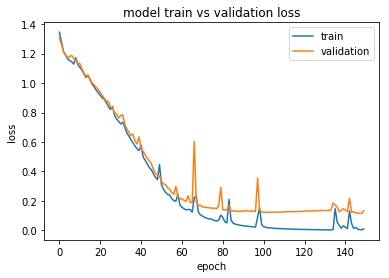


--------------------------------------------------
Iteration 151
Train on 6185 samples, validate on 687 samples
Epoch 1/1
6185/6185 [==============================] - 8s 1ms/step - loss: 0.0095 - acc: 0.9984 - val_loss: 0.1218 - val_acc: 0.9690
Q picnic           T picnicked         ☒ piccicked        
Q cocoon           T cocooned          ☑ cocooned         
Q turbocharge      T turbocharged      ☑ turbocharged     
Q screech          T screeched         ☑ screeched        
Q siphon           T siphoned          ☑ siphoned         
Q desalinize       T desalinized       ☑ desalinized      
Q portend          T portended         ☑ portended        
Q sun              T sunned            ☑ sunned           
Q relight          T relighted         ☑ relighted        
Q decrease         T decreased         ☑ decreased        

--------------------------------------------------
Iteration 152
Train on 6185 samples, validate on 687 samples
Epoch 1/1
6185/6185 [==============================

6185/6185 [==============================] - 9s 1ms/step - loss: 0.0019 - acc: 1.0000 - val_loss: 0.1225 - val_acc: 0.9713
Q rejudge          T rejudged          ☑ rejudged         
Q fuddle           T fuddled           ☑ fuddled          
Q pun              T punned            ☑ punned           
Q tally            T tallied           ☑ tallied          
Q evaporate        T evaporated        ☑ evaporated       
Q befog            T befogged          ☑ befogged         
Q scuffle          T scuffled          ☑ scuffled         
Q stratify         T stratified        ☑ stratified       
Q frisk            T frisked           ☑ frisked          
Q overprice        T overpriced        ☑ overpriced       

--------------------------------------------------
Iteration 161
Train on 6185 samples, validate on 687 samples
Epoch 1/1
6185/6185 [==============================] - 9s 1ms/step - loss: 0.0018 - acc: 1.0000 - val_loss: 0.1231 - val_acc: 0.9717
Q pine             T pined             ☑ 

6185/6185 [==============================] - 9s 1ms/step - loss: 0.0013 - acc: 1.0000 - val_loss: 0.1264 - val_acc: 0.9726
Q misinterpret     T misinterpreted    ☑ misinterpreted   
Q gird             T girded            ☑ girded           
Q eliminate        T eliminated        ☑ eliminated       
Q hotdog           T hotdogged         ☒ hoodogged        
Q release          T released          ☑ released         
Q berate           T berated           ☑ berated          
Q decrease         T decreased         ☑ decreased        
Q forestall        T forestalled       ☑ forestalled      
Q beef             T beefed            ☑ beefed           
Q chlorinate       T chlorinated       ☑ chlorinated      

--------------------------------------------------
Iteration 170
Train on 6185 samples, validate on 687 samples
Epoch 1/1
6185/6185 [==============================] - 8s 1ms/step - loss: 0.0013 - acc: 1.0000 - val_loss: 0.1271 - val_acc: 0.9729
Q manufacture      T manufactured      ☒ 

6185/6185 [==============================] - 8s 1ms/step - loss: 9.9194e-04 - acc: 1.0000 - val_loss: 0.1299 - val_acc: 0.9727
Q fiddle           T fiddled           ☑ fiddled          
Q assume           T assumed           ☑ assumed          
Q determine        T determined        ☑ determined       
Q vandalise        T vandalised        ☑ vandalised       
Q subtitle         T subtitled         ☒ subtttled        
Q decrease         T decreased         ☑ decreased        
Q golf             T golfed            ☑ golfed           
Q resurrect        T resurrected       ☑ resurrected      
Q honor            T honored           ☑ honored          
Q melt             T melted            ☑ melted           

--------------------------------------------------
Iteration 179
Train on 6185 samples, validate on 687 samples
Epoch 1/1
6185/6185 [==============================] - 8s 1ms/step - loss: 9.6427e-04 - acc: 1.0000 - val_loss: 0.1315 - val_acc: 0.9725
Q indicate         T indicated   

6185/6185 [==============================] - 8s 1ms/step - loss: 7.5416e-04 - acc: 1.0000 - val_loss: 0.1338 - val_acc: 0.9729
Q rebate           T rebated           ☑ rebated          
Q repatriate       T repatriated       ☑ repatriated      
Q roil             T roiled            ☑ roiled           
Q adjudge          T adjudged          ☑ adjudged         
Q ghost            T ghosted           ☑ ghosted          
Q surfboard        T surfboarded       ☒ subbboarded      
Q befog            T befogged          ☑ befogged         
Q distinguish      T distinguished     ☒ distiggiished    
Q desalinize       T desalinized       ☑ desalinized      
Q weatherproof     T weatherproofed    ☒ weathlrrroofed   

--------------------------------------------------
Iteration 188
Train on 6185 samples, validate on 687 samples
Epoch 1/1
6185/6185 [==============================] - 10s 2ms/step - loss: 7.3434e-04 - acc: 1.0000 - val_loss: 0.1339 - val_acc: 0.9730
Q nark             T narked     

6185/6185 [==============================] - 8s 1ms/step - loss: 5.8188e-04 - acc: 1.0000 - val_loss: 0.1365 - val_acc: 0.9731
Q decimate         T decimated         ☑ decimated        
Q cauterize        T cauterized        ☑ cauterized       
Q wed              T wedded            ☑ wedded           
Q evaporate        T evaporated        ☑ evaporated       
Q choose           T chose             ☒ choosed          
Q scintillate      T scintillated      ☑ scintillated     
Q garnish          T garnished         ☑ garnished        
Q transpose        T transposed        ☑ transposed       
Q backbite         T backbit           ☒ backbited        
Q turbocharge      T turbocharged      ☒ turbochorged     

--------------------------------------------------
Iteration 197
Train on 6185 samples, validate on 687 samples
Epoch 1/1
6185/6185 [==============================] - 8s 1ms/step - loss: 5.6604e-04 - acc: 1.0000 - val_loss: 0.1377 - val_acc: 0.9726
Q simplify         T simplified  

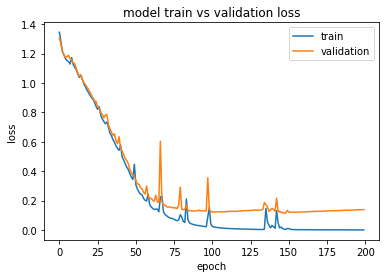


--------------------------------------------------
Iteration 201
Train on 6185 samples, validate on 687 samples
Epoch 1/1
6185/6185 [==============================] - 9s 1ms/step - loss: 5.0654e-04 - acc: 1.0000 - val_loss: 0.1385 - val_acc: 0.9734
Q dial             T dialed            ☑ dialed           
Q carbonize        T carbonized        ☑ carbonized       
Q refer            T referred          ☑ referred         
Q camber           T cambered          ☑ cambered         
Q drool            T drooled           ☑ drooled          
Q sin              T sinned            ☒ sanned           
Q jiggle           T jiggled           ☑ jiggled          
Q ween             T weened            ☑ weened           
Q placate          T placated          ☑ placated         
Q reassign         T reassigned        ☑ reassigned       

--------------------------------------------------
Iteration 202
Train on 6185 samples, validate on 687 samples
Epoch 1/1
6185/6185 [==========================

KeyboardInterrupt: 

In [17]:
# Train the model each generation and show predictions against the validation
# dataset. Also graph the loss and validation loss.

loss = []
val_loss = []
for iteration in range(1, 500):
    print()
    print('-' * 50)
    print('Iteration', iteration)
    history = model.fit(x_train, y_train,
              batch_size=BATCH_SIZE,
              epochs=1,
              validation_data=(x_val, y_val))
    loss.append(history.history['loss'])
    val_loss.append(history.history['val_loss'])
    if iteration % 1 == 0:
        classify_val_examples()
    if iteration % 50 == 0:
        plot_learning_curves(loss, val_loss)

In [48]:
def real_validation_accuracy(mod, x_val, y_val, verbose=False):
    num_correct = 0
    for i in range(len(x_val)):
        rowx, rowy = x_val[np.array([i])], y_val[np.array([i])]
        preds = model.predict_classes(rowx, verbose=0)
        q = ctable.decode(rowx[0])
        correct = ctable.decode(rowy[0])
        guess = ctable.decode(preds[0], calc_argmax=False)
        if correct == guess:
            num_correct += 1
        if verbose:
            print('Q', q[::-1] if REVERSE else q, end=' ')
            print('T', correct, end=' ')
            if correct == guess:
                print(colors.ok + '☑' + colors.close, end=' ')
            else:
                print(colors.fail + '☒' + colors.close, end=' ')
            print(guess)
    print("Validation Word Accuracy:", num_correct/len(x_val))
    return num_correct/len(x_val)

In [50]:
real_validation_accuracy(model, x_val, y_val, verbose=False)

Validation Word Accuracy: 0.7802037845705968


0.7802037845705968